# Integrating v2

In [1]:
%load_ext autoreload
%autoreload 2

In [1002]:
import os
import subprocess
import yaml

from astropy.io import fits
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
import random
import logging

from scipy import integrate
from scipy.interpolate import interp2d, RectBivariateSpline
import scipy.optimize as op
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [3]:
from gravitational_wave_toy import GWToyV2 as gwt
from gravitational_wave_toy import GWToy as gwto
from gravitational_wave_toy import GWPlotter as gwp

/Users/jarred/Documents/Projects/gravitational_wave_toy/.venv/lib/python3.7/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


## Import a sample grb

In [4]:
filepath = "./GammaCatalogV2.0/run0639_ID000222.fits"
filepath = "./GammaCatalogV2.0/run0016_ID000340.fits"

In [247]:
grb = gwt.GRB(filepath)

INFO:root:Got GRB run0016_ID000340, north, z40, 2.56º


In [248]:
with open("./gw_settings.yaml") as file:
    print("Settings file found!")
    parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)
    
sensitivity = gwt.Sensitivities(parsed_yaml_file["grbsens_files"], parsed_yaml_file["energy_limits"])

Settings file found!


## Test the extrapolations

In [249]:
time_index = 50
energy_index = 10

time = grb.time[time_index]
energy = grb.energy[energy_index]
print(f"Spectrum at t={time}s:")
print(grb.get_spectrum(time))
print()
print(f"Value at {energy} GeV:")
print(grb.get_spectrum(time, energy))
print()
print(f"Lightcurve at energy {energy} GeV:")
print(grb.get_flux(energy))
print()
print(f"LC value at t={time}s:")
print(grb.get_flux(energy, time))
print()
print("Spectral indices")
print(grb.power_law_slopes)

Spectrum at t=10000.0s:
[1.04168603e-06 6.29124848e-07 3.79959090e-07 2.29475771e-07
 1.38591578e-07 8.37021934e-08 5.05518250e-08 3.05307054e-08
 1.84389777e-08 1.11361953e-08 6.72568989e-09 4.06197119e-09
 2.45322193e-09 1.48162002e-09 8.94822382e-10 5.40426751e-10
 3.26389996e-10 1.97122791e-10 1.19052039e-10 7.19013071e-11
 4.34246624e-11 2.62261439e-11 1.58389466e-11 9.56505583e-12
 5.77498711e-12 3.48554021e-12 2.10269992e-12 1.26792985e-12
 7.64511320e-13 4.59613128e-13 2.74850017e-13 1.63707380e-13
 9.55582055e-14 5.63948409e-14 3.13733175e-14 1.75472036e-14
 8.79377525e-15 4.10965819e-15 1.70569349e-15 4.61341528e-16
 0.00000000e+00]

Value at 10.0 GeV:
6.725689885086982e-09

Lightcurve at energy 10.0 GeV:
[1.08445940e-13 1.70921199e-13 2.79319407e-13 4.33693028e-13
 6.82427056e-13 1.09708082e-12 1.72903451e-12 2.82555370e-12
 4.38715674e-12 6.90329556e-12 1.10978457e-11 1.74905587e-11
 2.85827211e-11 4.43795764e-11 6.98323196e-11 1.12263527e-10
 1.76930898e-10 2.89136934e-10 

In [7]:
grb.get_spectrum(time=10)

array([1.75889001e-07, 1.06227921e-07, 6.41562075e-08, 3.87470536e-08,
       2.34012299e-08, 1.41331407e-08, 8.53569096e-09, 5.15511886e-09,
       3.11342697e-09, 1.88034995e-09, 1.13563478e-09, 6.85865066e-10,
       4.14227267e-10, 2.50171990e-10, 1.51091030e-10, 9.12512207e-11,
       5.51110497e-11, 3.32842429e-11, 2.01019729e-11, 1.21405590e-11,
       7.33227395e-12, 4.42831680e-12, 2.67447586e-12, 1.61524603e-12,
       9.75525625e-13, 5.89167361e-13, 3.55826811e-13, 2.14901096e-13,
       1.29789176e-13, 7.83858963e-14, 4.73409029e-14, 2.85910632e-14,
       1.72668550e-14, 1.04267195e-14, 6.29426524e-15, 3.79546153e-15,
       2.27942414e-15, 1.35202096e-15, 7.72566494e-16, 3.73229175e-16,
       0.00000000e+00])

In [8]:
grb.get_flux(energy=10)

array([1.08445940e-13, 1.70921199e-13, 2.79319407e-13, 4.33693028e-13,
       6.82427056e-13, 1.09708082e-12, 1.72903451e-12, 2.82555370e-12,
       4.38715674e-12, 6.90329556e-12, 1.10978457e-11, 1.74905587e-11,
       2.85827211e-11, 4.43795764e-11, 6.98323196e-11, 1.12263527e-10,
       1.76930898e-10, 2.89136934e-10, 4.48934677e-10, 7.06409398e-10,
       1.13563478e-09, 1.78979661e-09, 2.92484982e-09, 4.54133095e-09,
       7.14589233e-09, 1.14878480e-08, 1.81052142e-08, 2.95871715e-08,
       4.59391169e-08, 7.22857105e-08, 1.16202895e-07, 1.83088607e-07,
       2.98447437e-07, 4.59325560e-07, 6.78836423e-07, 8.44071918e-07,
       7.65275302e-07, 5.92348363e-07, 4.37484010e-07, 3.17005432e-07,
       2.37204919e-07, 1.74175695e-07, 1.24076763e-07, 8.81175895e-08,
       6.23695622e-08, 4.47376526e-08, 3.14531814e-08, 2.17021139e-08,
       1.46783133e-08, 9.86055241e-09, 6.72568989e-09, 4.50088633e-09,
       2.96366649e-09, 1.94293129e-09, 1.26820102e-09, 8.15000739e-10,
      

## Test an integration

In [12]:
grb.get_integral_spectrum(10)

TypeError: get_integral_spectrum() missing 2 required positional arguments: 'min_energy' and 'max_energy'

In [155]:
grb.get_fluence(0, 3600*2)

TypeError: get_fluence() missing 2 required positional arguments: 'min_energy' and 'max_energy'

## Comparing numbers
for run0016_ID000340

In [15]:
t = grb.time[1]
grb.get_flux(t, grb.energy[0]) * (grb.energy[5]**(-grb.get_spectral_index(t)))

2.1556069489602007e-08

In [16]:
grb.get_flux(t, grb.energy[5])

1.7387561657620888e-08

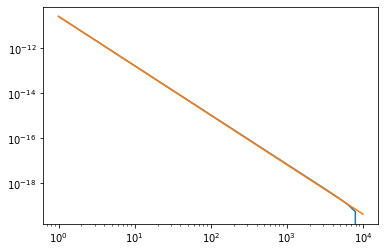

In [543]:
plt.loglog(grb.energy, [grb.get_flux(energy, t) for energy in grb.energy])
plt.loglog(grb.energy, [grb.power_law(energy, spectral_index=grb.get_spectral_index(t)) * grb.get_flux(grb.energy[0], t) for energy in grb.energy])
plt.show()

In [1067]:
plt.plot(grb.energy, np.array([grb.get_flux(energy, t) for energy in grb.energy])/np.array([grb.power_law(energy, spectral_index=grb.get_spectral_index(t)) * grb.get_flux(grb.energy[0], t) for energy in grb.energy]))
plt.xlim(0, 6000)
plt.ylim(0.9, 1.1)
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [98]:
res = gwt.observe_grb(filepath, sensitivity, log_directory=parsed_yaml_file["log_directory"], start_time=49602, zeniths=[20], sites=["north"], precision=2)

### Testing v2 stuff with v1 code

In [396]:
v2n = gwp.open_gw_file("gw_toy_results_log_v2.pkl")
v1n = gwp.open_gw_file("gw_toy_results_log.pkl")

In [66]:
files = {
    "north": {
        20: "grbsens_output_v1_July_2020/grbsens-5.0sigma_t1s-t16384s_irf-North_z20_0.5h.txt",
        40: "grbsens_output_v1_July_2020/grbsens-5.0sigma_t1s-t16384s_irf-North_z40_0.5h.txt",
        60: "grbsens_output_v1_July_2020/grbsens-5.0sigma_t1s-t16384s_irf-North_z60_0.5h.txt",
    },
    "south": {
        20: "grbsens_output_v1_July_2020/grbsens-5.0sigma_t1s-t16384s_irf-South_z20_0.5h.txt",
        40: "grbsens_output_v1_July_2020/grbsens-5.0sigma_t1s-t16384s_irf-South_z40_0.5h.txt",
        60: "grbsens_output_v1_July_2020/grbsens-5.0sigma_t1s-t16384s_irf-South_z60_0.5h.txt",
    },
}

interpolations = gwto.get_fit_dict(files)
spectral_dict = gwto.get_integral_spectra(zeniths=[20, 40, 60])

bns = gwto.ParseBNS("BNS-GW.txt", sep="\t")

gwto.observe_grb(
    413,
    bns,
    interpolations,
    spectral_dict,
    tstart=49602,
    zenith=20,
    observatory="north",
    precision=2
)

NEW LOOP; t=49603.00, dt=1.00, previous_t=49603.00, previous_dt=-1.00 n=1.00
    AUTOSTEP; t=49603.00 dt=10000.00
    AUTOSTEP; resetting n
    Updating t: 59602.00, obs_t: 10000.00 start_time: 49602.00, n: 1.00, dt: 10000.00
    Normalization_flux: 0.0004375156402580362 Integral_spectrum: 0.002933908000045386
    t=59602.00, dt=10000.00, avgflux=1.2836306370980314e-10, photon_flux=6.408230545297048e-12

Close solution, t=59602, avgflux=1.2836306370980314e-10, photon_flux=6.408230545297048e-12
NEW LOOP; t=59602.00, dt=1000.00, previous_t=49603.00, previous_dt=-1.00 n=0.00
    Updating t: 49603.00, obs_t: 1.00 start_time: 49603.00, n: 0.00, dt: 1000.00
    Normalization_flux: 5.167963219339084e-08 Integral_spectrum: 0.002933908000045386
    t=49603.00, dt=1000.00, avgflux=1.5162328633159247e-10, photon_flux=2.793960733894476e-09
    Updating n: 0.10
NEW LOOP; t=49603.00, dt=1000.00, previous_t=49603.00, previous_dt=1000.00 n=0.10
    Updating t: 49703.00, obs_t: 101.00 start_time: 49603

,run,id,ra,dec,eiso,z,angle,observatory,zenith,seen,tend,obstime,tstart
413,0016,000340,-77.259,17.294,2.090000e+51,0.054,2.56,north,20,True,49685.03,83.03,49602


In [400]:
v2n[v2n.run == "0016"][:10]

,run,id,ra,dec,eiso,z,angle,zenith,observatory,seen,tend,obstime,tstart
0,0016,000340,-77.259,17.294,2.090000e+51,0.054,2.56,20,North,True,86421.69,21.69,86400
0,0016,000340,-77.259,17.294,2.090000e+51,0.054,2.56,20,North,True,71821.01,12.01,71809
0,0016,000340,-77.259,17.294,2.090000e+51,0.054,2.56,20,North,True,59687.86,6.86,59681
0,0016,000340,-77.259,17.294,2.090000e+51,0.054,2.56,20,North,True,49606.04,4.04,49602
0,0016,000340,-77.259,17.294,2.090000e+51,0.054,2.56,20,North,True,41227.25,2.25,41225
0,0016,000340,-77.259,17.294,2.090000e+51,0.054,2.56,20,North,True,34264.26,1.26,34263
0,0016,000340,-77.259,17.294,2.090000e+51,0.054,2.56,20,North,True,28478.00,1.00,28477
0,0016,000340,-77.259,17.294,2.090000e+51,0.054,2.56,20,North,True,23669.00,1.00,23668
0,0016,000340,-77.259,17.294,2.090000e+51,0.054,2.56,20,North,True,19672.00,1.00,19671
0,0016,000340,-77.259,17.294,2.090000e+51,0.054,2.56,20,North,True,16350.00,1.00,16349


### Testing the v1 code.  [it works]

In [399]:
files = {
    "north": {
        20: "grbsens_output_v1_July_2020/grbsens-5.0sigma_t1s-t16384s_irf-North_z20_0.5h.txt",
        40: "grbsens_output_v1_July_2020/grbsens-5.0sigma_t1s-t16384s_irf-North_z40_0.5h.txt",
        60: "grbsens_output_v1_July_2020/grbsens-5.0sigma_t1s-t16384s_irf-North_z60_0.5h.txt",
    },
    "south": {
        20: "grbsens_output_v1_July_2020/grbsens-5.0sigma_t1s-t16384s_irf-South_z20_0.5h.txt",
        40: "grbsens_output_v1_July_2020/grbsens-5.0sigma_t1s-t16384s_irf-South_z40_0.5h.txt",
        60: "grbsens_output_v1_July_2020/grbsens-5.0sigma_t1s-t16384s_irf-South_z60_0.5h.txt",
    },
}

interpolations = gwto.get_fit_dict(files)
spectral_dict = gwto.get_integral_spectra(zeniths=[20, 40, 60])

bns = gwto.ParseBNS("BNS-GW.txt", sep="\t")

gwto.observe_grb(
    413,
    bns,
    interpolations,
    spectral_dict,
    tstart=49602,
    zenith=20,
    observatory="north",
    precision=2
)

,run,id,ra,dec,eiso,z,angle,observatory,zenith,seen,tend,obstime,tstart
413,0016,000340,-77.259,17.294,1.001666e+52,0.054,2.563,north,20,True,49673.99,71.99,49602


In [398]:
v1n[v1n.run == "0016"][0:10]

,run,id,ra,dec,eiso,z,angle,zenith,observatory,seen,tend,obstime,tstart
0,0016,000340,-77.259,17.294,1.001666e+52,0.054,2.563,20,North,True,86624.34,224.34,86400
0,0016,000340,-77.259,17.294,1.001666e+52,0.054,2.563,20,North,True,71960.77,151.77,71809
0,0016,000340,-77.259,17.294,1.001666e+52,0.054,2.563,20,North,True,59784.83,103.83,59681
0,0016,000340,-77.259,17.294,1.001666e+52,0.054,2.563,20,North,True,49673.99,71.99,49602
0,0016,000340,-77.259,17.294,1.001666e+52,0.054,2.563,20,North,True,41273.54,48.54,41225
0,0016,000340,-77.259,17.294,1.001666e+52,0.054,2.563,20,North,True,34295.67,32.67,34263
0,0016,000340,-77.259,17.294,1.001666e+52,0.054,2.563,20,North,True,28499.21,22.21,28477
0,0016,000340,-77.259,17.294,1.001666e+52,0.054,2.563,20,North,True,23683.27,15.27,23668
0,0016,000340,-77.259,17.294,1.001666e+52,0.054,2.563,20,North,True,19681.64,10.64,19671
0,0016,000340,-77.259,17.294,1.001666e+52,0.054,2.563,20,North,True,16356.27,7.27,16349


# Integration with the GW Toy

### Fluence calculation (S)

$S=\int_{t_0}^{t_\text{stop}} \int_{E_\text{min}}^{E_\text{max}} A \frac{E}{E_0}^{-\alpha} dE dt$

$S=\int_{t_0}^{t_\text{stop}} \int_{E_\text{min}}^{E_\text{max}} F(E_0, t) \frac{E}{E_0}^{\alpha(t)} dEdt$

In [ ]:
def power_law(self, energy, spectral_index=-2.1, energy_0=None, normalization=1):
    """The Power Law spectrum, including normalization"""

    if not energy_0:
        energy_0 = min(self.energy)

    return normalization * (energy / energy_0) ** (spectral_index)


def get_integral_spectrum(self, time, min_energy, max_energy):
    """Integrate the spectrum, including the normalization"""

    integral_spectrum = integrate.quad(
        lambda energy: self.power_law(
            energy,
            spectral_index=self.get_spectral_index(time),
            energy_0=min(self.energy),
            normalization=self.get_flux(energy=min(self.energy), time=time),
        ),
        min_energy,
        max_energy,
    )[0]

    return integral_spectrum

def get_fluence(self, start_time, stop_time, min_energy=None, max_energy=None):
    """Double integral: Integrate the integral spectrum from min_energy to max_energy, then integrate this in time"""
    
    fluence = integrate.quad(
        lambda time: self.get_integral_spectrum(time, min_energy, max_energy),
        start_time,
        stop_time,
    )[0]

    return fluence

# Speeding up the code

In [107]:
%time
res = gwt.observe_grb(filepath, sensitivity, log_directory=parsed_yaml_file["log_directory"], start_time=49602, zeniths=[20], sites=["north"], precision=2)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 3.1 µs


In [198]:
grb.time[:-3]

array([1.0000000e-01, 1.2589253e-01, 1.5848932e-01, 1.9952624e-01,
       2.5118864e-01, 3.1622776e-01, 3.9810717e-01, 5.0118721e-01,
       6.3095737e-01, 7.9432821e-01, 1.0000000e+00, 1.2589254e+00,
       1.5848932e+00, 1.9952623e+00, 2.5118864e+00, 3.1622777e+00,
       3.9810717e+00, 5.0118723e+00, 6.3095737e+00, 7.9432821e+00,
       1.0000000e+01, 1.2589254e+01, 1.5848932e+01, 1.9952623e+01,
       2.5118864e+01, 3.1622776e+01, 3.9810719e+01, 5.0118725e+01,
       6.3095734e+01, 7.9432823e+01, 1.0000000e+02, 1.2589254e+02,
       1.5848932e+02, 1.9952623e+02, 2.5118864e+02, 3.1622775e+02,
       3.9810718e+02, 5.0118723e+02, 6.3095734e+02, 7.9432825e+02,
       1.0000000e+03, 1.2589254e+03, 1.5848932e+03, 1.9952623e+03,
       2.5118865e+03, 3.1622776e+03, 3.9810718e+03, 5.0118726e+03,
       6.3095732e+03, 7.9432822e+03, 1.0000000e+04, 1.2589254e+04,
       1.5848932e+04, 1.9952623e+04, 2.5118865e+04, 3.1622777e+04,
       3.9810719e+04, 5.0118723e+04, 6.3095734e+04, 7.9432820e

In [110]:
catalog_directory = parsed_yaml_file["catalog"]

In [193]:
len(glob.glob(f"{catalog_directory}/*.fits"))

18949

In [123]:
%time
res = gwt.observe_grb(glob.glob(f"{catalog_directory}/*.fits")[0], sensitivity, log_directory=parsed_yaml_file["log_directory"], start_time=49602, zeniths=[20], max_angle=5, sites=["north"], precision=2)

print(res)

INFO:root:Got GRB run0810_ID000373, north, z20, 27.85º


CPU times: user 1e+03 ns, sys: 2 µs, total: 3 µs
Wall time: 5.01 µs
None


In [151]:
%time res = gwt.observe_grb(glob.glob(f"{catalog_directory}/*.fits")[0], sensitivity, log_directory=parsed_yaml_file["log_directory"], start_time=10, precision=0)

INFO:root:Got GRB run0810_ID000373, north, z60, 27.85º


CPU times: user 54.3 ms, sys: 13.9 ms, total: 68.3 ms
Wall time: 124 ms


In [270]:
for i in range(0,10):
    %time res = gwt.observe_grb(glob.glob(f"{catalog_directory}/*.fits")[i], sensitivity, log_directory=parsed_yaml_file["log_directory"], start_time=10000, precision=2)

INFO:root:Got GRB run0810_ID000373, north, z60, 27.85º
INFO:root:
Close solution, t=25000.0, avgflux=2.7068562987263122e-12, photon_flux=2.673438199794829e-12
INFO:root:
Close solution, t=24500.0, avgflux=2.736351619682363e-12, photon_flux=2.732700475693424e-12
INFO:root:
Close solution, t=24450.0, avgflux=2.7393449727828918e-12, photon_flux=2.7388119788429875e-12
INFO:root:
Close solution, t=24442.0, avgflux=2.739824661367303e-12, photon_flux=2.7397930518787046e-12
INFO:root:
Close solution, t=24441.5, avgflux=2.739854648804773e-12, photon_flux=2.739854398657556e-12
INFO:root:
Close solution, t=24441.5, avgflux=2.739854648804773e-12, photon_flux=2.739854398657556e-12
INFO:root:
Close solution, t=24441.5, avgflux=2.7398548287318486e-12, photon_flux=2.739854766748783e-12
INFO:root:dt=0.01, tend=24441.5, obst=14441.5
INFO:root:Got GRB run0785_ID000449, north, z40, 5.79º
INFO:root:
Close solution, t=20000, avgflux=1.1595645323795048e-09, photon_flux=6.022481324504629e-12


{'zenith': 60, 'site': 'north', 'min_energy': 110, 'max_energy': 10000, 'seen': True, 'obs_time': 14441.5, 'start_time': 10000, 'end_time': 24441.5, 'run': '0810', 'id': '000373', 'ra': -46.584, 'dec': -60.923, 'eiso': 3.88e+49, 'z': 0.056, 'angle': 27.85}
CPU times: user 3.38 s, sys: 24.2 ms, total: 3.4 s
Wall time: 3.41 s


INFO:root:
Close solution, t=10101.0, avgflux=2.241708039639426e-09, photon_flux=1.218726181258844e-10
INFO:root:
Close solution, t=10011.0, avgflux=2.260916536000133e-09, photon_flux=5.201435215107789e-10
INFO:root:
Close solution, t=10002.0, avgflux=2.2628542154329473e-09, photon_flux=1.5873597735864645e-09
INFO:root:
Close solution, t=10001.2, avgflux=2.263026602549788e-09, photon_flux=2.2175367262792302e-09
INFO:root:
Close solution, t=10001.17, avgflux=2.263033067539991e-09, photon_flux=2.254587394281554e-09
INFO:root:
Close solution, t=10001.16, avgflux=2.2630343605421377e-09, photon_flux=2.2621867249499504e-09
INFO:root:dt=0.01, tend=10001.16, obst=1.16
INFO:root:Got GRB run0325_ID000305, north, z60, 13.42º
INFO:root:
Close solution, t=20000, avgflux=6.686555426128631e-12, photon_flux=3.4749822295671003e-12


{'zenith': 40, 'site': 'north', 'min_energy': 40, 'max_energy': 10000, 'seen': True, 'obs_time': 1.16, 'start_time': 10000, 'end_time': 10001.16, 'run': '0785', 'id': '000449', 'ra': -39.481, 'dec': 18.193, 'eiso': 2.84e+51, 'z': 0.035, 'angle': 5.79}
CPU times: user 1.79 s, sys: 22.7 ms, total: 1.81 s
Wall time: 1.82 s


INFO:root:
Close solution, t=12801.0, avgflux=8.062867465090849e-12, photon_flux=7.913861592331585e-12
INFO:root:
Close solution, t=12711.0, avgflux=8.085431502300341e-12, photon_flux=8.08279043751528e-12
INFO:root:
Close solution, t=12710.0, avgflux=8.085683241161745e-12, photon_flux=8.084719217474336e-12
INFO:root:
Close solution, t=12709.5, avgflux=8.085809118968034e-12, photon_flux=8.085684047022526e-12
INFO:root:
Close solution, t=12709.43, avgflux=8.085826742306536e-12, photon_flux=8.085819146556277e-12
INFO:root:
Close solution, t=12709.43, avgflux=8.085827749357756e-12, photon_flux=8.085826866703251e-12
INFO:root:dt=0.01, tend=12709.43, obst=2709.43
INFO:root:Got GRB run0601_ID000209, south, z40, 9.36º
INFO:root:
Close solution, t=20000, avgflux=1.920291415817549e-11, photon_flux=3.900193720097296e-12


{'zenith': 60, 'site': 'north', 'min_energy': 110, 'max_energy': 10000, 'seen': True, 'obs_time': 2709.43, 'start_time': 10000, 'end_time': 12709.43, 'run': '0325', 'id': '000305', 'ra': -1.992, 'dec': 13.391, 'eiso': 9.74999999999999e+49, 'z': 0.033, 'angle': 13.42}
CPU times: user 4.51 s, sys: 35.8 ms, total: 4.55 s
Wall time: 4.56 s


INFO:root:
Close solution, t=10401.0, avgflux=3.15527499139507e-11, photon_flux=3.117715245342539e-11
INFO:root:
Close solution, t=10401.0, avgflux=3.15527499139507e-11, photon_flux=3.117715245342539e-11
INFO:root:
Close solution, t=10394.0, avgflux=3.156797416117168e-11, photon_flux=3.15340129067753e-11
INFO:root:
Close solution, t=10393.4, avgflux=3.15692798348061e-11, photon_flux=3.1565086763266565e-11
INFO:root:
Close solution, t=10393.32, avgflux=3.156945393343418e-11, photon_flux=3.156923583961277e-11
INFO:root:
Close solution, t=10393.32, avgflux=3.1569462638420007e-11, photon_flux=3.1569443329899244e-11
INFO:root:dt=0.01, tend=10393.32, obst=393.32
INFO:root:Got GRB run0437_ID000034, south, z20, 55.06º
INFO:root:
Close solution, t=20000, avgflux=3.4419539776285225e-11, photon_flux=5.8300298607017124e-12


{'zenith': 40, 'site': 'south', 'min_energy': 40, 'max_energy': 10000, 'seen': True, 'obs_time': 393.32, 'start_time': 10000, 'end_time': 10393.32, 'run': '0601', 'id': '000209', 'ra': 165.557, 'dec': 8.993, 'eiso': 4.52e+50, 'z': 0.082, 'angle': 9.36}
CPU times: user 2.78 s, sys: 36.1 ms, total: 2.81 s
Wall time: 2.81 s


INFO:root:
Close solution, t=10401.0, avgflux=5.062400316152968e-11, photon_flux=4.5250655000699474e-11
INFO:root:
Close solution, t=10341.0, avgflux=5.0775837469984196e-11, photon_flux=5.017313177394603e-11
INFO:root:
Close solution, t=10335.0, avgflux=5.0791081250132416e-11, photon_flux=5.074381025139652e-11
INFO:root:
Close solution, t=10334.5, avgflux=5.079235206247353e-11, photon_flux=5.0792122284566154e-11
INFO:root:
Close solution, t=10334.5, avgflux=5.079235206247353e-11, photon_flux=5.0792122284566154e-11
INFO:root:
Close solution, t=10334.5, avgflux=5.0792357145876594e-11, photon_flux=5.0792315770073697e-11
INFO:root:dt=0.01, tend=10334.5, obst=334.5
INFO:root:Got GRB run0127_ID000124, south, z40, 32.9º
INFO:root:
Close solution, t=20000, avgflux=4.239334763394451e-12, photon_flux=3.900193720097296e-12


{'zenith': 20, 'site': 'south', 'min_energy': 30, 'max_energy': 10000, 'seen': True, 'obs_time': 334.5, 'start_time': 10000, 'end_time': 10334.5, 'run': '0437', 'id': '000034', 'ra': -145.723, 'dec': 21.963, 'eiso': 1.13e+51, 'z': 0.038, 'angle': 55.06}
CPU times: user 3.24 s, sys: 33.8 ms, total: 3.27 s
Wall time: 3.29 s


INFO:root:
Close solution, t=18601.0, avgflux=4.3018273926825185e-12, photon_flux=4.299178087982626e-12
INFO:root:
Close solution, t=18601.0, avgflux=4.3018273926825185e-12, photon_flux=4.299178087982626e-12
INFO:root:
Close solution, t=18592.0, avgflux=4.302247167301869e-12, photon_flux=4.302087929615113e-12
INFO:root:
Close solution, t=18591.5, avgflux=4.3022704951795415e-12, photon_flux=4.302249734610978e-12
INFO:root:
Close solution, t=18591.43, avgflux=4.302273761141788e-12, photon_flux=4.302272388547484e-12
INFO:root:
Close solution, t=18591.43, avgflux=4.302273947768641e-12, photon_flux=4.302273683067319e-12
INFO:root:dt=0.01, tend=18591.43, obst=8591.43
INFO:root:Got GRB run0286_ID000021, south, z20, 7.52º
INFO:root:
Close solution, t=20000, avgflux=6.063030238854023e-11, photon_flux=5.8300298607017124e-12


{'zenith': 40, 'site': 'south', 'min_energy': 40, 'max_energy': 10000, 'seen': True, 'obs_time': 8591.43, 'start_time': 10000, 'end_time': 18591.43, 'run': '0127', 'id': '000124', 'ra': 57.598, 'dec': -63.337, 'eiso': 5.26e+50, 'z': 0.063, 'angle': 32.9}
CPU times: user 8.8 s, sys: 28.6 ms, total: 8.83 s
Wall time: 8.85 s


INFO:root:
Close solution, t=10201.0, avgflux=8.815061101741789e-11, photon_flux=7.026283542981773e-11
INFO:root:
Close solution, t=10141.0, avgflux=8.842269642351316e-11, photon_flux=8.806965557317349e-11
INFO:root:
Close solution, t=10141.0, avgflux=8.842269642351316e-11, photon_flux=8.806965557317349e-11
INFO:root:
Close solution, t=10140.2, avgflux=8.842633718704678e-11, photon_flux=8.83894976815404e-11
INFO:root:
Close solution, t=10140.11, avgflux=8.842674679433027e-11, photon_flux=8.842566693280314e-11
INFO:root:
Close solution, t=10140.11, avgflux=8.842675589676349e-11, photon_flux=8.842647112594164e-11
INFO:root:dt=0.01, tend=10140.11, obst=140.11
INFO:root:Got GRB run0248_ID000057, north, z20, 49.61º


{'zenith': 20, 'site': 'south', 'min_energy': 30, 'max_energy': 10000, 'seen': True, 'obs_time': 140.11, 'start_time': 10000, 'end_time': 10140.11, 'run': '0286', 'id': '000021', 'ra': -72.029, 'dec': 68.822, 'eiso': 2.09e+51, 'z': 0.062, 'angle': 7.52}
CPU times: user 2.58 s, sys: 26.6 ms, total: 2.6 s
Wall time: 2.62 s


INFO:root:Got GRB run0552_ID000375, north, z20, 54.6º


{'zenith': 20, 'site': 'north', 'min_energy': 30, 'max_energy': 10000, 'seen': False, 'obs_time': -1, 'start_time': 10000, 'end_time': -1, 'run': '0248', 'id': '000057', 'ra': 178.302, 'dec': 40.454, 'eiso': 2.65e+49, 'z': 0.028, 'angle': 49.61}
CPU times: user 2.67 s, sys: 15.7 ms, total: 2.69 s
Wall time: 2.72 s


INFO:root:Got GRB run0241_ID000319, south, z20, 43.89º


{'zenith': 20, 'site': 'north', 'min_energy': 30, 'max_energy': 10000, 'seen': False, 'obs_time': -1, 'start_time': 10000, 'end_time': -1, 'run': '0552', 'id': '000375', 'ra': -62.914, 'dec': -21.142, 'eiso': 1.05e+52, 'z': 0.018, 'angle': 54.6}
CPU times: user 2.73 s, sys: 29.2 ms, total: 2.76 s
Wall time: 2.78 s
{'zenith': 20, 'site': 'south', 'min_energy': 30, 'max_energy': 10000, 'seen': False, 'obs_time': -1, 'start_time': 10000, 'end_time': -1, 'run': '0241', 'id': '000319', 'ra': -139.646, 'dec': -41.483, 'eiso': 1.67e+48, 'z': 0.028, 'angle': 43.89}
CPU times: user 2.73 s, sys: 16.4 ms, total: 2.74 s
Wall time: 2.77 s


In [ ]:
for i in range(5,11):
    %time res = gwt.observe_grb(glob.glob(f"{catalog_directory}/*.fits")[i], sensitivity, log_directory=parsed_yaml_file["log_directory"], start_time=3602, precision=0)

In [205]:
np.vectorize(grb.get_spectral_index())

TypeError: get_spectral_index() missing 1 required positional argument: 'time'

In [166]:
max(grb.time)/3600/24

9.19361400462963

In [167]:
6*3600*24

518400

In [267]:
%time res = gwt.observe_grb(glob.glob(f"{catalog_directory}/*.fits")[4], sensitivity, log_directory=parsed_yaml_file["log_directory"], start_time=153, precision=0)

INFO:root:Got GRB run0437_ID000034, south, z20, 55.06º
INFO:root:NEW LOOP; t=154.00, dt=1.00, previous_t=154.00, previous_dt=-1.00 n=1.00
INFO:root:
Close solution, t=253, avgflux=3.6922258906539567e-10, photon_flux=1.0962147722050396e-10
INFO:root:NEW LOOP; t=253.00, dt=10.00, previous_t=154.00, previous_dt=-1.00 n=0.00
INFO:root:NEW LOOP; t=154.00, dt=10.00, previous_t=154.00, previous_dt=10.00 n=0.10
INFO:root:NEW LOOP; t=155.00, dt=10.00, previous_t=155.00, previous_dt=10.00 n=0.20
INFO:root:NEW LOOP; t=156.00, dt=10.00, previous_t=156.00, previous_dt=10.00 n=0.30
INFO:root:NEW LOOP; t=157.00, dt=10.00, previous_t=157.00, previous_dt=10.00 n=0.40
INFO:root:NEW LOOP; t=158.00, dt=10.00, previous_t=158.00, previous_dt=10.00 n=0.50
INFO:root:NEW LOOP; t=159.00, dt=10.00, previous_t=159.00, previous_dt=10.00 n=0.60
INFO:root:NEW LOOP; t=160.00, dt=10.00, previous_t=160.00, previous_dt=10.00 n=0.70
INFO:root:NEW LOOP; t=161.00, dt=10.00, previous_t=161.00, previous_dt=10.00 n=0.80
INFO:

{'zenith': 20, 'site': 'south', 'min_energy': 30, 'max_energy': 10000, 'seen': True, 'obs_time': 28.0, 'start_time': 153, 'end_time': 181.0, 'run': '0437', 'id': '000034', 'ra': -145.723, 'dec': 21.963, 'eiso': 1.13e+51, 'z': 0.038, 'angle': 55.06}
CPU times: user 2.79 s, sys: 49.2 ms, total: 2.84 s
Wall time: 2.84 s


In [208]:
grb.power_law_slopes

[-2.190630065812002,
 -2.1906424971334917,
 -2.190623329741619,
 -2.190642602715898,
 -2.1906468440009066,
 -2.1906354673043396,
 -2.190644364111233,
 -2.190623974331183,
 -2.1906428075362467,
 -2.1906469143657907,
 -2.1906354870156806,
 -2.190644370935923,
 -2.190623976319507,
 -2.1906428081449216,
 -2.1906469145519303,
 -2.190635487074621,
 -2.190644370954106,
 -2.190623976325624,
 -2.1906428081467104,
 -2.19064691455252,
 -2.19063548707479,
 -2.190644370954165,
 -2.190623976325656,
 -2.190642808146792,
 -2.190646914553102,
 -2.190635487077937,
 -2.190644370975011,
 -2.19062397649959,
 -2.1906428089215226,
 -2.190646920478805,
 -2.1906355192682345,
 -2.1906445841173268,
 -2.1906257420988013,
 -2.190650552772459,
 -2.190697038786485,
 -2.1909002023559956,
 -2.191637362981365,
 -2.193293678484103,
 -2.195153099929331,
 -2.197040568399985,
 -2.1982966086600015,
 -2.199657673584009,
 -2.201651713716415,
 -2.203198497022747,
 -2.2041132930283283,
 -2.2060191312903963,
 -2.2088689290623584

In [140]:
%timeit grb.get_spectral_index(time=2343)

79.5 µs ± 2.54 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [141]:
%timeit grb.get_spectral_index(time=43200)

77.2 µs ± 513 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
%timeit grb.get_fluence(10, 43200)

In [143]:
%timeit grb.get_fluence(10, 43200)

9.95 s ± 129 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [146]:
%timeit grb.get_integral_spectrum(10, grb.min_energy, grb.max_energy)

5.78 ms ± 123 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [148]:
%timeit grb.get_integral_spectrum(43200, grb.min_energy, grb.max_energy)

5.74 ms ± 31.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [144]:
print("time_delays:  # in seconds\n# log scale from 10s to 12h (25 bins)")
for i in np.logspace(1, np.log10(12*3600), 25):
    print(f"    - {round(i)}")

time_delays:  # in seconds
# log scale from 10s to 12h (25 bins)
    - 10
    - 14
    - 20
    - 28
    - 40
    - 57
    - 81
    - 115
    - 163
    - 231
    - 327
    - 464
    - 657
    - 932
    - 1320
    - 1871
    - 2653
    - 3760
    - 5329
    - 7553
    - 10705
    - 15172
    - 21504
    - 30479
    - 43200


# Testing analytic solution

In [455]:
%timeit grb.get_integral_spectrum(1000, grb.min_energy, grb.max_energy)

13.6 ms ± 438 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [456]:
%timeit grb.get_fast_integral_spectrum(1000, min(grb.energy))

54.4 µs ± 1.57 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
%timeit grb.get_fluence(10, 90000)

In [ ]:
%timeit grb.get_fast_fluence(10, 90000)

In [914]:
%time gwt.observe_grb(glob.glob(f"{catalog_directory}/*.fits")[35], sensitivity, log_directory=parsed_yaml_file["log_directory"], start_time=60000, precision=1, read=False)

INFO:root:Got GRB run0116_ID000033, south, z40, 23.56º
INFO:root:dt=0.1, tend=60053.5, obst=53.5


CPU times: user 1.93 s, sys: 18.2 ms, total: 1.95 s
Wall time: 1.99 s


,zenith,site,min_energy,max_energy,seen,obs_time,start_time,end_time,run,id,ra,dec,eiso,z,angle
000033_0116,40,south,40,10000,True,53.5,60000,60053.5,0116,000033,169.073,17.637,4.500000e+51,0.047,23.56


In [941]:
%time gwt.observe_grb(glob.glob(f"{catalog_directory}/*.fits")[40], sensitivity, log_directory=parsed_yaml_file["log_directory"], start_time=10, target_precision=1, read=False)

CPU times: user 114 ms, sys: 27 ms, total: 141 ms
Wall time: 177 ms


,zenith,site,min_energy,max_energy,seen,obs_time,start_time,end_time,run,id,ra,dec,eiso,z,angle
000162_0482,20,south,30,10000,True,4,10,14,0482,000162,111.549,13.198,4.550000e+47,0.03,16.48


In [939]:
np.isfinite(np.array([1,2,np.nan])) 

array([ True,  True, False])

In [935]:
the_grb.get_get_spectrum

array([1.0000000e+00, 1.2589254e+00, 1.5848932e+00, 1.9952623e+00,
       2.5118864e+00, 3.1622777e+00, 3.9810717e+00, 5.0118723e+00,
       6.3095737e+00, 7.9432821e+00, 1.0000000e+01, 1.2589254e+01,
       1.5848932e+01, 1.9952623e+01, 2.5118864e+01, 3.1622776e+01,
       3.9810719e+01, 5.0118725e+01, 6.3095734e+01, 7.9432823e+01,
       1.0000000e+02, 1.2589254e+02, 1.5848932e+02, 1.9952623e+02,
       2.5118864e+02, 3.1622775e+02, 3.9810718e+02, 5.0118723e+02,
       6.3095734e+02, 7.9432825e+02, 1.0000000e+03, 1.2589254e+03,
       1.5848932e+03, 1.9952623e+03, 2.5118865e+03, 3.1622776e+03,
       3.9810718e+03, 5.0118726e+03, 6.3095732e+03, 7.9432822e+03,
       1.0000000e+04], dtype=float32)

In [920]:
i = 0
while i < 2:
    print(i)
    i += 1
else:
    "done with loop!"

0
1


In [905]:
gwt.check_if_visible(the_grb, sensitivity, 100000, 100000+100)

INFO:root:    visible:True avgflux=7.906039213055426e-11, photon_flux=7.649489489993954e-11


True

# Individual Detectability chart

/Users/jarred/Documents/Projects/gravitational_wave_toy/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


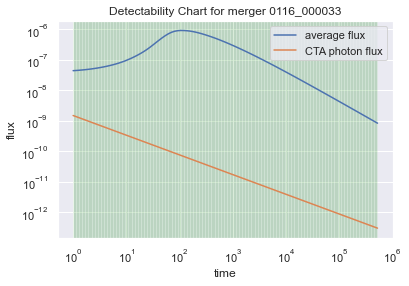

In [1078]:
grb_index = 35
delay = 10     # seconds
max_time = 24*6  # consecutive dark hours observing the source



the_grb = gwt.GRB(glob.glob(f"{catalog_directory}/*.fits")[grb_index])
times = np.logspace(0, np.log10(max_time*3600), 100)
fluences = np.array([the_grb.get_fast_fluence(delay, delay+time)/(time) for time in times])
sensitivites = np.array([sensitivity.get(t=time, site=the_grb.site, zenith=the_grb.zenith) for time in times])


plt.loglog(times, fluences, label="average flux")
plt.loglog(times, sensitivites, label="CTA photon flux")

visible_matrix = np.greater(fluences, sensitivites)
for idx, time in enumerate(times[:-1]):
    plt.axvspan(times[idx], times[idx+1], facecolor='green' if visible_matrix[idx] else 'red', alpha=0.2)
plt.title(f"Detectability Chart for merger {the_grb.run}_{the_grb.id}")
plt.xlabel("time")
plt.ylabel("flux")
plt.legend()
plt.show()

### Plotting the new results

In [984]:
v1 = gwp.open_gw_file("./results/gw_toy_results_log_v2.pkl")
v2 = gwp.open_gw_file("./results/gw_toy_v2_new_algo.pkl")

In [1031]:
v2

,zenith,site,min_energy,max_energy,seen,obs_time,start_time,end_time,run,id,ra,dec,eiso,z,angle
000373_0810,20,south,30,10000,True,72,1227,1299,810,373,-46.584,-60.923,3.880000e+49,0.056,27.85
000373_0810,20,south,30,10000,True,1055,7801,8856,810,373,-46.584,-60.923,3.880000e+49,0.056,27.85
000373_0810,20,south,30,10000,True,2,44,46,810,373,-46.584,-60.923,3.880000e+49,0.056,27.85
000373_0810,20,south,30,10000,True,43,847,890,810,373,-46.584,-60.923,3.880000e+49,0.056,27.85
000373_0810,20,south,30,10000,True,609,5388,5997,810,373,-46.584,-60.923,3.880000e+49,0.056,27.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
000164_0562,40,north,40,10000,True,8,77,85,562,164,-141.295,57.538,3.330000e+49,0.074,6.96
000164_0562,40,north,40,10000,True,10,92,102,562,164,-141.295,57.538,3.330000e+49,0.074,6.96
000297_0865,40,south,40,10000,False,-1,5388,-1,865,297,37.088,-36.200,3.070000e+51,0.033,51.64
000297_0865,40,south,40,10000,False,-1,3722,-1,865,297,37.088,-36.200,3.070000e+51,0.033,51.64


Plot settings file found!


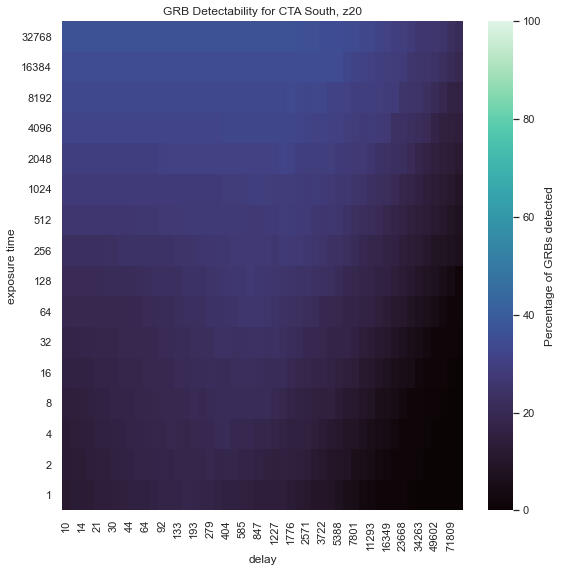

In [1049]:
# load in the settings
with open("./plot_settings.yaml") as file:
    print("Plot settings file found!")
    parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)

input_file = parsed_yaml_file["input_file"]
output_dir = parsed_yaml_file["output_directory"]
sites = parsed_yaml_file["sites"]
zeniths = parsed_yaml_file["zeniths"]
obs_times = parsed_yaml_file["observation_times"]
annotate = parsed_yaml_file["show_percents"]
log_scale = parsed_yaml_file["log_scale"]
color_scheme = parsed_yaml_file["color_scheme"]
x_tick_labels = parsed_yaml_file.get("x_tick_labels")
y_tick_labels = parsed_yaml_file.get("y_tick_labels")
min_value = parsed_yaml_file["min_value"]
max_value = parsed_yaml_file["max_value"]


######

reduce = v2.angle > 10

gwp.plot_toy(
    data=v2[reduce],
    output_dir="v2_tests",
    site="south",
    zenith=20,
    min_value=0,
    max_value=100,
    color_scheme="mako",
    show_only = True
)

In [1059]:
the_grb.time[-1]/(24*3600)

9.19361400462963

In [1080]:
isinstance(v2, type(None))

False

In [1063]:
9*24*3600

777600

In [1065]:
print("time_delays:  # in seconds\n# log scale from 10s to 9 days (50 bins)")
for i in np.logspace(1, np.log10(9*24*3600), 50):
    print(f"    - {round(i)}")

time_delays:  # in seconds
# log scale from 10s to 9 days (50 bins)
    - 10
    - 13
    - 16
    - 20
    - 25
    - 32
    - 40
    - 50
    - 63
    - 79
    - 100
    - 125
    - 158
    - 198
    - 250
    - 314
    - 395
    - 497
    - 626
    - 788
    - 991
    - 1247
    - 1570
    - 1975
    - 2486
    - 3128
    - 3936
    - 4953
    - 6233
    - 7844
    - 9871
    - 12421
    - 15630
    - 19669
    - 24751
    - 31146
    - 39193
    - 49320
    - 62063
    - 78099
    - 98277
    - 123670
    - 155624
    - 195834
    - 246433
    - 310106
    - 390231
    - 491059
    - 617938
    - 777600
